## Segmentation multi-organes en IRM abdominale </font></br></div>

P.-H. Conze <span style="color:blue">pierre-henri.conze@imt-atlantique.fr</span>

F. Rousseau <span style="color:blue">francois.rousseau@imt-atlantique.fr</span>

A. Lamouroux <span style="color:blue">alix.lamouroux@imt-atlantique.fr</span>

E. Lhermitte <span style="color:blue">emma.lhermitte@univ-brest.fr</span>

L'objectif de ce projet est de développer un **modèle de segmentation multi-organes** (foie, reins et rate) à partir d'images IRM T2 abdominales.

Les **Données** (22,8Mo) sont disponibles sur Moodle. Vous disposez de **12 examens** (à charger dans la session Colab), 8 pour l'apprentissage et 4 pour le test !


### 1 - Gestion des données

La fonction `read_train_exam(exam_nb)` fournie ci-dessous permets de lire pour un examen d'apprentissage d'indice `exam_nb` :
- l'image acquise en modalité T2
- un masque de segmentation vérité-terrain (1 : foie, 2 : rein droit, 3 : rein gauche, 4 : rate)

La fonction `read_test_exam(exam_nb)` permets de lire l'image T2 correspondant à l'examen de test d'indice `exam_nb`.

In [6]:
import nibabel

def read_train_exam(exam_nb):
    image = nibabel.load('chaos-data/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    mask = nibabel.load('chaos-data/%02d-T2SPIR-mask.nii.gz'%(exam_nb))
    return image, mask

def read_test_exam(exam_nb):
    image = nibabel.load('chaos-data/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    return image

Les examens 1, 2, 3, 5, 8, 10, 13 et 19 serviront d'examens d'apprentissage tandis que les examens 21, 22, 32 et 39 serviront d'examens de test. Les masques associés aux examens d'apprentissage sont fournis. Les masques associés aux examens de test seront fournis à la fin du projet (début de séance 10), pour évaluation.

In [7]:
train_ids = [1,2,3,5,8,10,13,19]
test_ids = [21,22,32,39]

Visualisons les examens d'apprentissage.

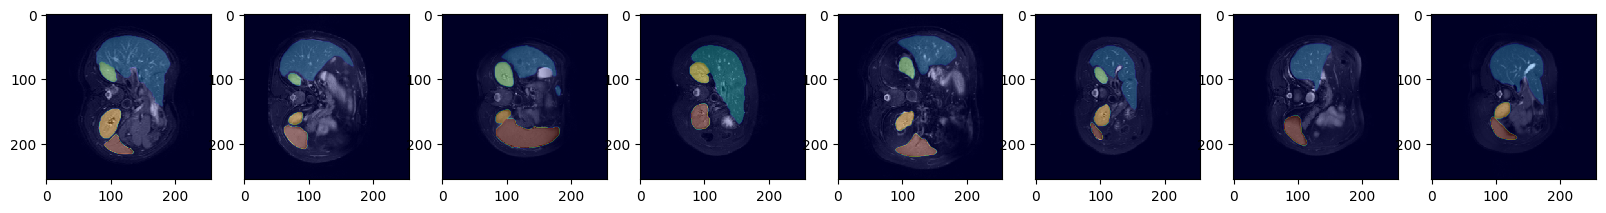

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize # from scipy.misc import imresize

img_slices, mask_slices = [], []
for train_id in train_ids:
    image, mask = read_train_exam(train_id)
    a = np.unique(np.where(mask.get_fdata()>0.)[2])
    z = a[int(1*len(a)/2)]
    img_slices.append(resize(image.get_fdata()[:,:,z],(256,256),mode='reflect',anti_aliasing=True))
    mask_slices.append(resize(mask.get_fdata()[:,:,z],(256,256),mode='reflect',anti_aliasing=True))

plt.figure(figsize=(20, 15))
for i in range(len(train_ids)):
    plt.subplot(1, len(train_ids), i+1)
    plt.imshow(img_slices[i], cmap='gray', interpolation='nearest')
    plt.imshow(mask_slices[i], cmap='jet', alpha=0.3)
plt.show()

Pendant vos expérimentations, des examens d'apprentissage peuvent être utilisés comme "données de test" pour valider les modèles obtenus.

In [9]:
test_id_1, test_id_2 = 13, 19
slice_1, slice_2 = 13, 13
image_1, mask_1 = read_train_exam(test_id_1)
image_2, mask_2 = read_train_exam(test_id_2)
slice_im_1 = image_1.get_fdata()[:,:,slice_1]
slice_im_2 = image_2.get_fdata()[:,:,slice_2]
slice_mask_1 = mask_1.get_fdata()[:,:,slice_1].astype(np.uint8)
slice_mask_2 = mask_2.get_fdata()[:,:,slice_2].astype(np.uint8)

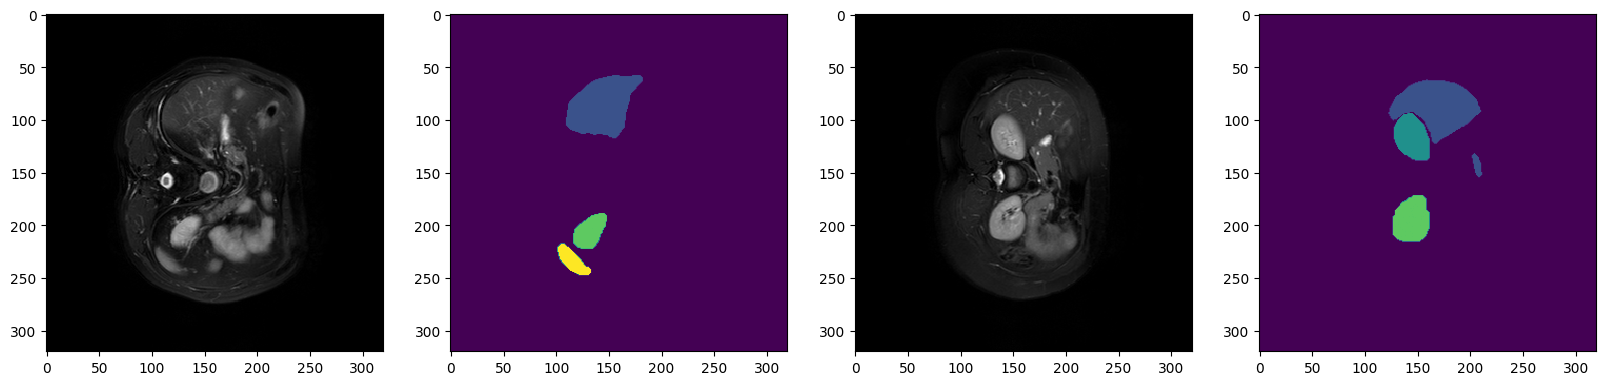

In [10]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 4, 1)
plt.imshow(slice_im_1, cmap='gray', interpolation='nearest')
plt.subplot(1, 4, 2)
plt.imshow(slice_mask_1,vmin=0,vmax=4)
plt.subplot(1, 4, 3)
plt.imshow(slice_im_2, cmap='gray', interpolation='nearest')
plt.subplot(1, 4, 4)
plt.imshow(slice_mask_2,vmin=0,vmax=4)
plt.show()

In [16]:
print(slice_im_1.max())

1538.0


### 2 - Baseline

Reprenons l'approche par apprentissage statistique étudiée lors du TP I.3.

In [6]:
from skimage.restoration import denoise_tv_bregman

def exam2vec(image, mask):
    vec_img = image.get_fdata().flatten()
    vec_tvb = denoise_tv_bregman(image.get_fdata(),weight=1.0).flatten()
    (X,Y,Z) = np.where(np.ones(shape=image.shape,dtype=bool))
    X = np.array(X, dtype=float)/image.shape[0]
    Y = np.array(Y, dtype=float)/image.shape[1]
    Z = np.array(Z, dtype=float)/image.shape[2]
    data = np.column_stack((vec_img,vec_tvb,X,Y,Z))
    if mask is not None:
        vec_mask = mask.get_fdata().flatten()
        return data, vec_mask
    else:
        return data

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

for idx, train_id in enumerate(train_ids[:6]):
    image, mask = read_train_exam(train_id)
    data, vec_mask = exam2vec(image, mask)
    if idx > 0:
        train_data = np.concatenate((train_data, data),axis=0)
        train_mask = np.concatenate((train_mask, vec_mask),axis=0)
    else:
        train_data = data
        train_mask = vec_mask

scaler = StandardScaler()
scaler.fit(train_data)
scaler.transform(train_data)

clf = RandomForestClassifier(n_estimators=20, random_state=0)
factor = 16
clf.fit(train_data[::factor,:], train_mask[::factor])

NameError: name 'train_ids' is not defined

In [8]:
image_1, mask_1 = read_train_exam(test_id_1)
data = exam2vec(image_1, None)
scaler.transform(data)
estimation_1 = clf.predict(data)
seg_1 = np.reshape(estimation_1, image_1.shape)

In [9]:
image_2, mask_2 = read_train_exam(test_id_2)
data = exam2vec(image_2, None)
scaler.transform(data)
estimation_2 = clf.predict(data)
seg_2 = np.reshape(estimation_2, image_2.shape)

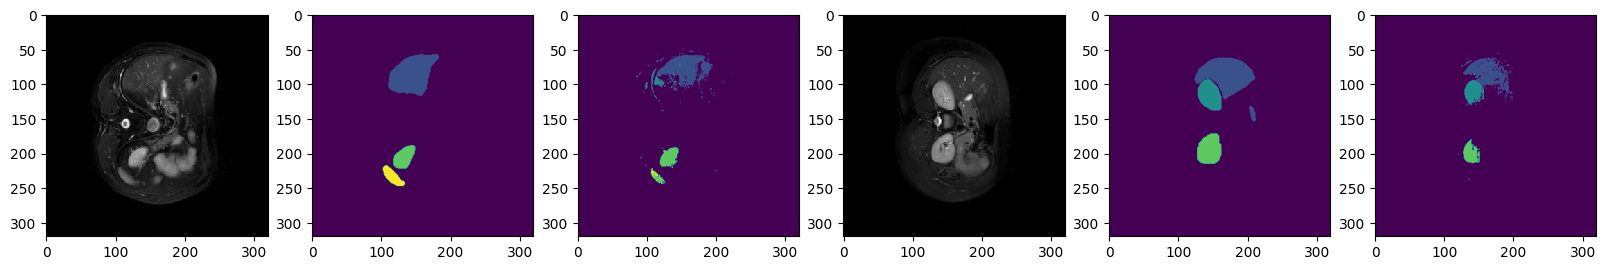

In [10]:
slice_seg_1 = seg_1[:,:,slice_1].astype(np.uint8)
slice_seg_2 = seg_2[:,:,slice_2].astype(np.uint8)
plt.figure(figsize=(20, 15))
plt.subplot(1, 6, 1)
plt.imshow(slice_im_1, cmap='gray', interpolation='nearest')
plt.subplot(1, 6, 2)
plt.imshow(slice_mask_1,vmin=0,vmax=4)
plt.subplot(1, 6, 3)
plt.imshow(slice_seg_1,vmin=0,vmax=4)
plt.subplot(1, 6, 4)
plt.imshow(slice_im_2, cmap='gray', interpolation='nearest')
plt.subplot(1, 6, 5)
plt.imshow(slice_mask_2,vmin=0,vmax=4)
plt.subplot(1, 6, 6)
plt.imshow(slice_seg_2,vmin=0,vmax=4)
plt.show()

La qualité des délimitations obtenues est loin d'être parfaite. A vous de jouer pour tenter d'améliorer ces résultats !

### 3 - Evaluation

Le code fourni ci-dessous permets de calculer le score Dice.

In [11]:
def compute_dice(res, gt, label):
    A = gt == label
    B = res == label
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0:
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

In [12]:
def compute_dice_exam(seg, mask):
    dice_liver = compute_dice(seg, mask, 1)
    dice_rkidney = compute_dice(seg, mask, 2)
    dice_lkidney = compute_dice(seg, mask, 3)
    dice_spleen = compute_dice(seg, mask, 4)
    return dice_liver, dice_rkidney, dice_lkidney, dice_spleen

In [13]:
print(compute_dice_exam(seg_1, mask_1.get_fdata()))
print(compute_dice_exam(seg_2, mask_2.get_fdata()))

(79.51522929323247, 52.86675896309734, 48.78025939972843, 58.665497011897585)
(83.88555062615825, 55.121574222697824, 40.154256897063185, 44.636151425961636)


Pour le challenge, vous serez amené à fournir les scores Dices obtenus pour chaque organe sur les données de test.